## <span style=color:darkblue> Assignment: K Nearest Neighbor and VDM </span>

- Ashlea Pin Jui Huang - 989357938

In this assignment, we will be applying KNN algorithm to a healthcare dataset. We will be using features pre-rx-cost, numofgen, numofbrand, generic-cost, adjust-total-30d, num-er, region and pdc-80-flag.


In [3]:
pip install progressbar

Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
import progressbar

### Problem 1
In this problem, we apply KNN to the healthcare data to predict adherent class (pdc-80-flag).

In [6]:
def linear_normalized(argin):
    """ linear normalization

    arg (array): the array to be normalized

    return (array): normalized array
    """
    Max = max(argin)
    Min = min(argin)
    return np.array([(i - Min) / (Max - Min) for i in argin])

In [7]:
# train data
train = pd.read_csv('/Users/AshleaHuang/Desktop/healthcareTrain.csv')
train_y = np.array(train.pdc_80_flag)
train_X = np.array(train[['pre_rx_cost','numofgen','numofbrand','generic_cost','adjust_total_30d','num_er']].apply(linear_normalized, 0))

# get train min max for each features to normalize test
get_train_max_min = lambda argin: (max(argin), min(argin))
train_max_min = [get_train_max_min(train[['pre_rx_cost','numofgen','numofbrand','generic_cost','adjust_total_30d','num_er']].iloc[:,i]) for i in range(6)]

# test data
test = pd.read_csv('/Users/AshleaHuang/Desktop/healthcareTest.csv')
test_y = np.array(test.pdc_80_flag)
test_X_raw = np.array(test[['pre_rx_cost','numofgen','numofbrand','generic_cost','adjust_total_30d','num_er']])

# normalized test X
test_X = np.array([[(i-train_max_min[j][1]) / (train_max_min[j][0] - train_max_min[j][1])\
                    for i in test_X_raw.transpose()[j]] for j in range(test_X_raw.shape[1])]).transpose()

#### Part 1

Predict the pdc-80-flag using the following features ”pre-rx- cost”,”numofgen”,”numofbrand”,”generic-cost”,”adjust-total-30d”, and ”num- er”. Determine the accuracy rate for test set for k = 75 to 105 with a step
size of 2 and report it in a table. Use linear normalization method to normalize the input features and Euclidean distance for distance measure. Note that you must use the training parameters for normalization of test points. You can use built-in knn function in R for this problem.

In [8]:
def knn_get_score(k):
    """ KNN using the inputed train and test
    arg (int): number of neighbors

    return (float): accuracy
    """
    model = KNeighborsClassifier(n_neighbors = k, p=2)
    model.fit(train_X, train_y)
    return model.score(test_X, test_y)

In [9]:
# accuracy for k from 75 to 106
accuracy = [knn_get_score(i) for i in range(75,106,2)]

In [10]:
pd.DataFrame({'K':list(range(75,106,2)), 'Accuracy':accuracy})

,K,Accuracy
0,75,0.668605
1,77,0.665698
2,79,0.668605
3,81,0.665698
4,83,0.662791
5,85,0.665698
6,87,0.665698
7,89,0.665698
8,91,0.665698
9,93,0.654070


#### Part 2
 Plot the accuracy rate vs. K. Which value of K gives you the best accuracy rate?

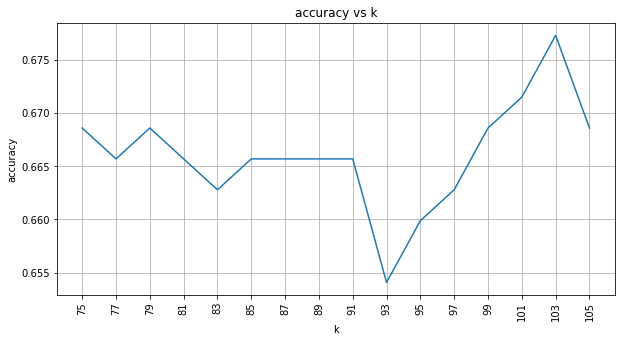

In [11]:
plt.figure(figsize=(10,5))
plt.plot(range(75,106,2), accuracy)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.xticks(range(75,106,2), rotation=90)
plt.title('accuracy vs k')
plt.grid()
plt.show()

In [12]:
print('Best K:', list(range(75,106,2))[np.argmax(accuracy)])
print('Best Accuracy:', max(accuracy))

Best K: 103
Best Accuracy: 0.6773255813953488


### Problem 2

In this problem we’ll continue using the healthcare data from the previous problem. We’ll use the Value Distance Metric (VDM) to find the distance between symbolic feature values Northeast, Midwest, South, and West, and further use this information in KNN algorithm to predict pdc-80-flag.

#### Part 1
Find all the relevant conditional probabilities for finding VDM for symbolic variable region and report your results in a table.

In [13]:
region_class = train[['regionN','pdc_80_flag']]
con_prop = [j/sum(j) for j in [np.unique(region_class[region_class.regionN == i].pdc_80_flag, return_counts=True)[1] for i in np.unique(region_class.regionN)]]

pd.DataFrame(np.array(con_prop).transpose(), columns=['Northeast','Midwest','South','West'])

,Northeast,Midwest,South,West
0,0.495495,0.568579,0.645995,0.576087
1,0.504505,0.431421,0.354005,0.423913


#### Part 2
Use results in part 1 to find the distance between symbolic feature values Northeast, Midwest, South, and West using VDM equation. Report the distances in a table.

0 denotes as Northeast
1 denotes as Midwest
2 denotes as South
3 denotes as West
So, (0,1) denotes as the VDM distance between Northeast and Midwest.

In [14]:
region_comb = [(i,j) for j in range(1,4) for i in range(4) if i<j]
vdm_distance = [((con_prop[i[0]] - con_prop[i[1]])**2).sum() for i in region_comb]

In [15]:
pd.DataFrame({'Combination':region_comb, 'VDM Distance':vdm_distance})

,Combination,VDM Distance
0,"(0, 1)",0.010682
1,"(0, 2)",0.045300
2,"(1, 2)",0.011987
3,"(0, 3)",0.012990
4,"(1, 3)",0.000113
5,"(2, 3)",0.009774


#### Part 3
Use this variable (region) in conjunction with the variables of problem 1 and regenerate your model, for k = 75 to 105 with a step size of 2. Report the mean accuracy rate. Compare this mean with mean accuracy rate from previous problem. Has it increased for decreased?

In [16]:
train_region_class = region_class.regionN
test_regioin_class = test.regionN

In [17]:
# 1 test point to all train point's region combination
def vdm_one_test_dist(te_vdm):
    """ return dist using vdm from 1 test to all train
    """
    te_vdm_to_all = [tuple(sorted((te_vdm-1, i-1))) for i in train_region_class]
    te_vdm_to_all_dist = [vdm_distance[region_comb.index(i)] if i in region_comb else 0 for i in te_vdm_to_all]
    return te_vdm_to_all_dist

# 1 test point to all train point's the rest 6 features
def one_test_dist(te):
    """ return square different from 1 test to all train
    """
    return np.array([i.sum() for i in ((te - train_X)**2)])

# combine the above two functions and do KNN classification
def knn_one_point(te_point, k):
    """ knn for 1 test point

    arg: te_point (int) - test point index, k (int) number of neighbors

    return (int): class result
    """
    value, counts = np.unique([train_y[i] for i in np.argsort(np.sqrt(one_test_dist(test_X[te_point]) + vdm_one_test_dist(test_regioin_class[te_point])))[:k]], return_counts=True)
    return value[np.argmax(counts)]

def knn_score(k):
    progress = progressbar.ProgressBar()
    return (np.array([knn_one_point(i, k) for i in progress(range(len(test_y)))]) == test_y).sum() / len(test_y)

In [18]:
progress = progressbar.ProgressBar()
accuracy_rate = [knn_score(i) for i in progress(range(75,106,2))]

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |##################################

In [19]:
print('Mean Accuracy Rate:', round(np.mean(accuracy_rate), 3))
print('Mean Accuracy Rate (Problem 1):', round(np.mean(accuracy), 3))

Mean Accuracy Rate: 0.645
Mean Accuracy Rate (Problem 1): 0.666


In [20]:
accuracy_rate

[0.6598837209302325,
 0.6482558139534884,
 0.6482558139534884,
 0.6511627906976745,
 0.6482558139534884,
 0.6511627906976745,
 0.6337209302325582,
 0.6453488372093024,
 0.6453488372093024,
 0.6482558139534884,
 0.6395348837209303,
 0.6366279069767442,
 0.6337209302325582,
 0.6308139534883721,
 0.6424418604651163,
 0.6540697674418605]

#### Part 4
Plot the accuracy rate vs. K. Which value of K gives you the best accuracy rate?

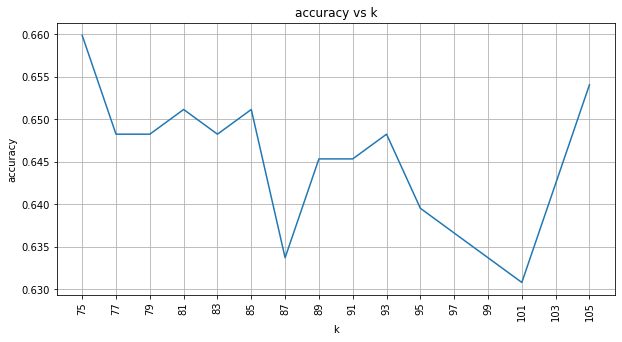

In [30]:
# plot
plt.figure(figsize=(10,5))
plt.plot(range(75,106,2), accuracy_rate)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.xticks(range(75,106,2), rotation=90)
plt.title('accuracy vs k')
plt.grid()
plt.show()

In [31]:
best_k_2 = np.array([i for i in range(len(accuracy_rate)) if accuracy_rate[i] == max(accuracy_rate)])
print('Best k:', best_k_2+75, '\naccuracy:', round(accuracy_rate[best_k_2[0]], 4))

Best k: [75] 
accuracy: 0.6599


#### Part 5
What did your model predict for the 100th,200th, and 300th test points?

In [32]:
for i in (100, 200, 300):
    print('Model Prediction of {}th Observation:'.format(i), knn_one_point(i-1, 75))

Model Prediction of 100th Observation: 0
Model Prediction of 200th Observation: 0
Model Prediction of 300th Observation: 0
